In [1]:
# coding=utf-8
#
# This file is part of b-swarm
# Licensed under the GNU General Public License version 3 (GPLv3)
#
# Author: BB, 2024
# __version__ = "code_version"
__license__ = "gplv3"
__author__ = "bb"
__version__ = "0.9"


from binascii import unhexlify
from io import BytesIO
from math import sqrt, prod

import numpy as np
import pandas as pd
from ppdeep import compare as ppcompare
from PIL import Image, ImageChops
from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS


def ppdeep_diff(ppdeep1, ppdeep2):
    if ppdeep1 and ppdeep2:
        return ppcompare(ppdeep1, ppdeep2)
    else:
        return None

def sha256_match(hash1, hash2):
    if hash1 and hash2:
        return hash1 == hash2
    else:
        return None

def ssl_match(fprint1, fprint2):
    if fprint1 and fprint2:
        return fprint1 == fprint2
    else:
        return None

def url_match(url1, url2):
    if url1 and url2:
        if url1.endswith('/'):
            url1 = url1[:-1]
        if url2.endswith('/'):
            url2 = url2[:-1]
        return url1 == url2
    else:
        return None

def image_load(image, grayscale=True, grayscaleconvert=False, size=(1500, 3000), resize=False, subsample=False, factor=2):
    if image:
        image = unhexlify(image)
        pilImage = Image.open(BytesIO(image))
        if resize:
            resizedImage = pilImage.resize(size)
        if grayscaleconvert:
            grayscaleImage = pilImage.convert("L")
    else:
        if grayscale:
            pilImage = Image.new('L', (size[0], size[1]))
        else:
            pilImage = Image.new('RGB', (size[0], size[1]), (0xff, 0xff, 0xff))
    if subsample:
        imageArray = np.array(pilImage)
        pilImage = Image.fromarray(imageArray[::factor, ::factor])
    return pilImage

def image_mse(image1, image2):
    npImage1 = np.array(image1)
    npImage2 = np.array(image2)
    squared_diff = np.square(npImage1 - npImage2)
    mse = np.mean(squared_diff)
    return mse

def image_diff(image1, image2):
    diff = ImageChops.difference(image1, image2)
    return diff

def calculate_rmse(mseValues):
    sqMseSum = sum(mse ** 2 for mse in mseValues)
    rmse = sqrt(sqMseSum / len(mseValues))
    return rmse

def calculate_arithmetic_mean(values, handlenone=True, nonevalue=0):
    if handlenone:
        values = [nonevalue if value == None else value for value in values]
    return sum(values) / len(values)

def calculate_normalized_diff(ent1, ent2, handleinf=True, inf=1e32):
    absDiff = abs(ent1 - ent2)
    average = (ent1 + ent2) / 2
    if average != 0:
        normDiff = absDiff / average
    else:
        if handleinf:
            normDiff = inf
        else:
            normDiff = float("inf")
    return float(normDiff)

def cluster_dbscan(df, eps=1.3, samples=1):
    dbscan = DBSCAN(eps=eps, min_samples=samples)
    dbscan.fit(scaledDf)
    return list(dbscan.labels_)

def cluster_hdbscan(df, samples=2):
    hdbscan = HDBSCAN(min_cluster_size=samples)
    hdbscan.fit(scaledDf)
    return list(hdbscan.labels_)

def cluster_optics(df, samples=2):
    optics = OPTICS(min_cluster_size=samples)
    optics.fit(scaledDf)
    return list(optics.labels_)

In [2]:
from time import time

import clickhouse_connect as cc


def convert_image_array(image, resize_width=128, resize=True):
    img = image_load(image)
    if resize:
        imgWidth, imgHeight = img.size
        aspect = imgHeight // imgWidth
        img = img.resize((resize_width, resize_width * aspect)).convert('L')
    return np.asarray(img).flatten()

def convert_sha256_value(sha256_hash):
    if sha256_hash:
        return int(sha256_hash, 16)
    else:
        return 0

def calculate_mean_ppdeep(ppdeepNpArray):
    hashDiffList = []
    npArrayLen = len(ppdeepNpArray)
    for i in range(0, npArrayLen):
        hashList = []
        fhash1 = ppdeepNpArray[i]
        for j in range(0, npArrayLen):
            if i == j:
                continue
            fhash2 = ppdeepNpArray[j]
            hashList.append(ppdeep_diff(fhash1, fhash2))
        hashDiffList.append(calculate_arithmetic_mean(hashList))
    return hashDiffList

def calculate_mean_mse(imgNpArray):
    mseDiffList = []
    npArrayLen = len(imgNpArray)
    for i in range(0, npArrayLen):
        mseList = []
        img1 = imgNpArray[i]
        for j in range(0, npArrayLen):
            if i == j:
                continue
            img2 = imgNpArray[j]
            squared_diff = np.square(img1 - img2)
            mse = np.mean(squared_diff)
            mseList.append(mse)
        mseDiffList.append(calculate_rmse(mseList))
    return mseDiffList

def db_connect(db_host="localhost", db_username="default", db_password=""):
    client = cc.get_client(host=db_host, username=db_username, password=db_password)
    return client

def create_snapshot_diff(cc_client, snapshot_db="harvester", snapshot_table="snapshot", diff_table="difference", verbose=True):
    cc_client.command(f"DROP TABLE IF EXISTS {snapshot_db}.{diff_table}")
    cc_client.command(f"CREATE TABLE IF NOT EXISTS {snapshot_db}.{diff_table} (url_init String, meta_agentid String, diff_fuzzyhash Float64, diff_mse Float64) ENGINE = MergeTree() ORDER BY url_init")
    
    urlList = cc_client.query(f"SELECT DISTINCT url.init FROM {snapshot_db}.{snapshot_table} ORDER BY url.init").result_columns[0]
    u = 0
    ucount = len(urlList)
    for url in urlList:
        startTime = time()
        diffDf = client.query_df(f"SELECT url.init, meta.agentid, http.fuzzyhash, http.image FROM {snapshot_db}.{snapshot_table} WHERE url.init=='{url}' ORDER BY meta.agentid ASC")
        # Process sha256 - can be queried and processed from the snapshot table directly
        # diffDf['http.sha256'] = diffDf['http.sha256'].apply(convert_sha256_value)
        # Process fuzzy-hash CTPH
        diffDf['http.fuzzyhash'] = calculate_mean_ppdeep(diffDf['http.fuzzyhash'].to_numpy())
        # Process PNG image MSE, SSIM
        diffDf['http.image'] = diffDf['http.image'].apply(convert_image_array, resize=False)
        diffDf['diff_mse'] = calculate_mean_mse(diffDf['http.image'].to_numpy())
        diffDf = diffDf.drop('http.image', axis=1)

        # Fixed in harvester syntax 0.52. While the snapshot file still uses dot synatx, retain this. Modify once the new snapshot format becomes the main one.
        # Modify everywhere in the code!
        diffDf.rename(columns={'url.init': 'url_init', 'meta.agentid': 'meta_agentid', 'http.fuzzyhash': 'diff_fuzzyhash'}, inplace=True)
        
        diffSchema = {
            "url_init": "string",
            "meta_agentid": "string",
            "diff_fuzzyhash": "float64",
            "diff_mse": "float64"
            }
        diffDf = diffDf.astype(diffSchema)
        status = cc_client.insert_df(database=snapshot_db, table=diff_table, df=diffDf)
        endTime = time()
        u += 1
        if verbose:
            print(f"{int(u / ucount * 100)}%  \t ({u}/{ucount}) \t {round((endTime - startTime), 2)}s \t {url}")

def export_diff_parquet(cc_client, diff_file=None, snapshot_db="harvester", diff_table="difference", method="clickhouse"):
    if not diff_file:
        agentId = cc_client.command(f"SELECT meta_agentid from {snapshot_db}.{diff_table} LIMIT 1")
        taskId = agentId.split(":")[-1]
        diff_file = f"{taskId}_diff.parquet"
    if method.lower() == "clickhouse":
        try:
            status = cc_client.command(f"SET engine_file_allow_create_multiple_files = 1")
            status = cc_client.command(f"INSERT INTO FUNCTION file('{diff_file}') SELECT * FROM {snapshot_db}.{diff_table} FORMAT Parquet SETTINGS compression = 'snappy'")
            return status
        except Exception as err:
            return err
    if method.lower() == "pandas":
        df = cc_client.query_df(f"SELECT * FROM {snapshot_db}.{diff_table} ORDER BY url_init ASC")
        try:
            df.to_parquet(diff_file, engine="fastparquet", index=False, compression="snappy")
        except Exception as err:
            return err

def load_db(cc_client, snapshot_db="harvester", snapshot_table="snapshot", diff_table="difference", snapshot_file="report*.parquet", diff_file="*_diff.parquet", clean_init=True):
    if clean_init:
        cc_client.command(f"DROP TABLE IF EXISTS {snapshot_db}.{snapshot_table}")
        cc_client.command(f"DROP TABLE IF EXISTS {snapshot_db}.{diff_table}")
        cc_client.command(f"DROP DATABASE IF EXISTS {snapshot_db}")
        cc_client.command(f"CREATE DATABASE {snapshot_db}")
    try:
        cc_client.command(f"CREATE TABLE {snapshot_db}.{snapshot_table} ENGINE = MergeTree ORDER BY tuple() AS SELECT * FROM file('{snapshot_file}', Parquet)")
        cc_client.command(f"CREATE TABLE {snapshot_db}.{diff_table} ENGINE = MergeTree ORDER BY tuple() AS SELECT * FROM file('{diff_file}', Parquet)")
    except Exception as err:
        return err


client = db_connect()
#create_snapshot_diff(client)
#export_diff_parquet(client)
#load_db(client)

https://linkedin.com
Raw DBSCAN: 	 [2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, -1, 0, 2, 0, 2, 1, 0]
Robust DBSCAN: 	 [-1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, -1, 0, 0, 1, 1, 0, 0]
Robust HDBSCAN:  [-1, 1, 1, 1, 0, 2, 0, 2, 1, 2, 0, -1, 1, 1, 0, -1, 2, 1]
Robust OPTICS: 	 [-1, 0, 0, 0, 2, 1, 2, 1, 0, 1, 2, -1, 0, 0, 2, 2, 1, 0]
Raw OPTICS: 	 [-1, 0, 0, 1, 0, -1, 1, 2, 0, 2, -1, -1, 0, -1, 1, -1, 2, 1]
Affinity: 	 [0, 3, 3, 3, 1, 4, 1, 4, 3, 4, 1, 2, 3, 3, 1, 1, 4, 3]
[[-3.34862385e+00  4.94855203e-01]
 [-4.58715596e-02  1.12687252e-01]
 [-4.58715596e-02  1.18255747e-01]
 [ 2.29357798e-01 -1.41200091e-01]
 [-5.96330275e-01  9.45580013e-02]
 [ 4.12844037e-01 -5.54203018e-01]
 [-7.79816514e-01 -9.45580013e-02]
 [ 3.21100917e-01 -6.56074668e-01]
 [ 2.29357798e-01  1.57941421e-01]
 [ 5.04587156e-01 -7.17473172e-01]
 [-6.88073394e-01 -3.23213209e-01]
 [-1.35917431e+02  2.01108765e+00]
 [ 4.58715596e-02  1.78078119e-01]
 [ 4.58715596e-02  4.71930662e-01]
 [-5.04587156e-01 -9.45580013e-02]
 [-5.04587156e-01  

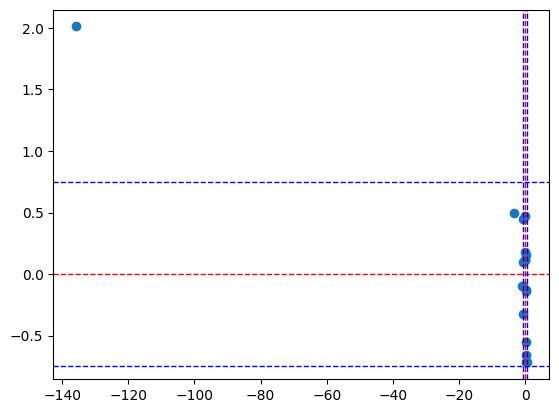

[+] Cluster: -1 length 2


[+] Cluster: 0 length 7


[+] Cluster: 2 length 5


[+] Cluster: 1 length 4


In [38]:
##### import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler
# from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AffinityPropagation
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

from ipywidgets import HBox
from ipywidgets import Image as ipyImage
from IPython.display import display
# from ipywidgets import interact


def display_image_cluster(image_list, cluster_list, image_ratio=5):
    imgWidgets = []
    for image in image_list:
        img = image_load(image)
        IMAGE_RATIO = image_ratio
        reimg = ( img.resize((
            int(img.width // IMAGE_RATIO),
            int(img.height // IMAGE_RATIO)
            )) )
        imgWidgets.append(ipyImage(value=reimg._repr_png_(), format='png'))
    clusters = {}
    for i in range(0, len(cluster_list)):
        cluster = cluster_list[i]
        widget = imgWidgets[i]
        if cluster not in clusters.keys():
            clusters[cluster] = []
        clusters[cluster].append(widget)
    imgHboxes = []
    for key, val in clusters.items():
        print(f"[+] Cluster: {key} length {len(val)}")
        display(HBox(val))


snapshotDb = "harvester"
snapshotTable = "snapshot"
diffTable = "difference"
urlList = client.query(f"SELECT DISTINCT url_init FROM {snapshotDb}.{diffTable} ORDER BY url_init ASC").result_columns[0]
agentList = client.query(f"SELECT DISTINCT meta_agentid FROM {snapshotDb}.{diffTable} ORDER BY meta_agentid ASC").result_columns[0]

url = urlList[14]
print(url)
frame = client.query_np(f"SELECT diff_fuzzyhash, diff_mse FROM {snapshotDb}.{diffTable} WHERE url_init=='{url}' ORDER BY meta_agentid ASC")
totalframe = client.query_np(f"SELECT diff_fuzzyhash, diff_mse FROM {snapshotDb}.{diffTable} ORDER BY meta_agentid ASC")

samples = 3

eps= 2
dbscan = DBSCAN(eps=eps, min_samples=samples)
dbscan.fit(frame)
rdlabels = list(dbscan.labels_)
print("Raw DBSCAN: \t", rdlabels)

eps = 0.5
scaler = RobustScaler(quantile_range=(25.0, 95.0))
#scaler = MinMaxScaler()
frame2 = scaler.fit_transform(frame)
dbscan = DBSCAN(eps=eps, min_samples=samples)
dbscan.fit(frame2)
dlabels = list(dbscan.labels_)
print("Robust DBSCAN: \t", dlabels)

hdbscan = HDBSCAN(min_cluster_size=samples)
hdbscan.fit(frame2)
hlabels = list(hdbscan.labels_)
print("Robust HDBSCAN: ", hlabels)

optics = OPTICS(min_samples=samples, metric="minkowski", max_eps=1)
optics.fit(frame2)
olabels = list(optics.labels_)
print("Robust OPTICS: \t", olabels)

optics.fit(frame)
rolabels = list(optics.labels_)
print("Raw OPTICS: \t", rolabels)

affinity = AffinityPropagation()
affinity.fit(frame2)
alabels = list(affinity.labels_)
print("Affinity: \t", alabels)

print(frame2)
plt.scatter(x=frame2[:, 0], y=frame2[:, 1])
xmedian = np.median(frame2[:, 0])
ymedian = np.median(frame2[:, 1])
plt.axvline(xmedian, color='red', linestyle='dashed', linewidth=1)
plt.axhline(ymedian, color='red', linestyle='dashed', linewidth=1)
threshold = 0.75
plt.axvline((xmedian + threshold), color='blue', linestyle='dashed', linewidth=1)
plt.axvline((xmedian - threshold), color='blue', linestyle='dashed', linewidth=1)
plt.axhline((ymedian + threshold), color='blue', linestyle='dashed', linewidth=1)
plt.axhline((ymedian - threshold), color='blue', linestyle='dashed', linewidth=1)
plt.show()

images = client.query(f"select http.image from harvester.snapshot where url.init=='{url}' order by meta.agentid asc").result_columns[0]
zlabels = [0] * 18
display_image_cluster(images, olabels)

In [20]:
imageDf = client.query_df(f"select http.image from harvester.snapshot where url.init=='{url}' order by meta.agentid asc")
imageDf['http.image'] = imageDf['http.image'].apply(convert_image_array, resize=False)
data = np.array([img for img in imageDf['http.image'].to_list()])

[-1, 0, 0, 2, 0, 1, -1, 1, 0, 1, -1, -1, 0, 2, -1, 2, 1, 2]


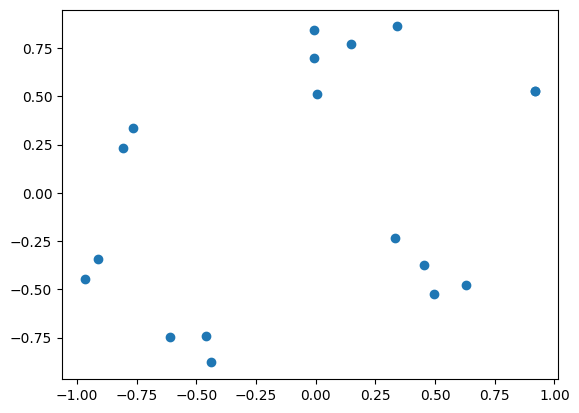

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


pca = PCA(n_components=2)
fitdata = pca.fit_transform(data)
tsne = TSNE(n_components=2, perplexity=2)
fitdata = tsne.fit_transform(fitdata)
scaler = RobustScaler()
fitdata = scaler.fit_transform(fitdata)
plt.scatter(fitdata[:, 0], fitdata[:, 1])
plt.plot()
clustering = OPTICS(min_samples=3).fit(data)
labels = list(clustering.labels_)
print(labels)

In [22]:
images = client.query(f"select http.image from harvester.snapshot where url.init=='{url}' order by meta.agentid asc").result_columns[0]
display_image_cluster(images, labels)

[+] Cluster: -1 length 5


[+] Cluster: 0 length 5


[+] Cluster: 2 length 4


[+] Cluster: 1 length 4


In [ ]:
_, axs = plt.subplots(1, 3, figsize=(20, 7))

xmedian = np.median(totalframe[:, 0])
ymedian = np.median(totalframe[:, 1])
axs[0].scatter(totalframe[:, 0], totalframe[:, 1])
axs[0].axvline(xmedian, color='red', linestyle='dashed', linewidth=1)
axs[0].axhline(ymedian, color='red', linestyle='dashed', linewidth=1)

scaler = RobustScaler(quantile_range=(25.0, 75.0))
scaler = MinMaxScaler()
rtotalframe = scaler.fit_transform(totalframe)
xmedian = np.median(rtotalframe[:, 0])
ymedian = np.median(rtotalframe[:, 1])
axs[1].scatter(rtotalframe[:, 0], rtotalframe[:, 1])
axs[1].axvline(xmedian, color='red', linestyle='dashed', linewidth=1)
axs[1].axhline(ymedian, color='red', linestyle='dashed', linewidth=1)

arrayList = []
for url in urlList:
    frame = client.query_np(f"SELECT diff_fuzzyhash, diff_mse FROM {snapshotDb}.{diffTable} WHERE url_init=='{url}' ORDER BY meta_agentid ASC")
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    scaler = MinMaxScaler()
    frame = scaler.fit_transform(frame)
    arrayList.append(frame)

totalarray = np.vstack(arrayList)
xmedian = np.median(totalarray[:, 0])
ymedian = np.median(totalarray[:, 1])
axs[2].scatter(totalarray[:, 0], totalarray[:, 1])
axs[2].axvline(xmedian, color='red', linestyle='dashed', linewidth=1)
axs[2].axhline(ymedian, color='red', linestyle='dashed', linewidth=1)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example list of floating-point values
values = totalarray[:, 0]

# Calculate the median value using NumPy
median_value = np.median(values)

# Create a histogram to visualize the value distribution
plt.hist(values, bins=10, color='skyblue', edgecolor='black')

# Add a vertical line for the median value
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Value Distribution')

# Add legend for the median line
plt.legend(['Median'])

# Show the plot
plt.show()

# Print the calculated median value
print("Median value:", median_value)


In [ ]:
threshold = 0.9
selectList = []
for cluster in clusterList:
    dbscanVal = sum(cluster[0][0])
    fuzzyVal = cluster[0][1][1]
    mseVal = cluster[0][1][3]
    #print(dbscanVal, fuzzyVal, mseVal, dbscanVal == 0 or (fuzzyVal == 100.0 or mseVal == 0.0))
    if dbscanVal == 0 or (fuzzyVal >= 100.0 - threshold * 10 or mseVal <= 0.0 + threshold):
        continue
    selectList.append((cluster[1], fuzzyVal, mseVal, cluster[0][0]))
    print(cluster[1], fuzzyVal, mseVal, cluster[0][0])

print(len(selectList))

In [30]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import display, clear_output


def load_url(button_click):
    global snapshotDf
    snapshotDf = client.query_df(f"select * from {snapshotDb}.{snapshotTable} where url.init=='{urlLayer.value}' ORDER BY meta.agentid ASC")
    with output1:
        current = {}
        current['new'] = agentLayer1.value
        update_output1(current)
    with output2:
        current = {}
        current['new'] = agentLayer2.value
        update_output2(current)
    with output3:
        output3.clear_output()
        metadata3.value = ""
    dbscanVal = str(clusterList[urllist.index(urlLayer.value)][0][0])
    frameDiff = str(clusterList[urllist.index(urlLayer.value)][0][1])
    hdbscanVal = str(clusterList[urllist.index(urlLayer.value)][0][2])
    opticsVal = str(clusterList[urllist.index(urlLayer.value)][0][3])
    metadata4.value = f"{dbscanVal}\n{hdbscanVal}\n{opticsVal}\n{frameDiff}"
        
def single_snapshot():
    return 0
    analyze_snapshot(urllist, snapshotTable, singleUrl=urllist.index(urlLayer.value))

def compare_images(button_click):
    snapshotEntry1 = snapshotDf[(snapshotDf["meta.agentid"] == agentList[agentLayer1.value])]
    image1 = snapshotEntry1["http.image"].item()
    snapshotEntry2 = snapshotDf[(snapshotDf["meta.agentid"] == agentList[agentLayer2.value])]
    image2 = snapshotEntry2["http.image"].item()
    imgDiff = image_diff(image1, image2)
    with output3:
        output3.clear_output()
        display(imgDiff[0].resize((
            int(imgDiff[0].width // IMAGE_RATIO),
            int(imgDiff[0].height // IMAGE_RATIO)
            )))
        ppdeep1 = snapshotEntry1['http.fuzzyhash'].item()
        ppdeep2 = snapshotEntry2['http.fuzzyhash'].item()
        sha256_1 = snapshotEntry1['http.sha256'].item()
        sha256_2 = snapshotEntry2['http.sha256'].item()
        ent1 = snapshotEntry1['http.entropy'].item()
        ent2 = snapshotEntry2['http.entropy'].item()
        metadata3.value = (f"Content SHA256 match: {sha256_match(sha256_1, sha256_2)}\n"
                           f"Content Ppdeep similarity: {ppdeep_diff(ppdeep1, ppdeep2)}\n"
                           f"Image Mean squared error: {round(imgDiff[1], 4)}\n"
                           f"URL match: {url_match(snapshotEntry1['url.init'].item(), snapshotEntry1['url.end'].item())}"
                           f" | {url_match(snapshotEntry2['url.init'].item(), snapshotEntry2['url.end'].item())}\n"
                           f"SSL match: {snapshotEntry1['http.ssl'].item() == snapshotEntry2['http.ssl'].item()}"
                          )

def update_output1(change):
    index = change['new']
    with output1:
        output1.clear_output()
        snapshotEntry = snapshotDf[(snapshotDf["meta.agentid"] == agentList[agentLayer1.value])]
        image = image_load(snapshotEntry["http.image"].item())
        display(image.resize((
            int(image.width // IMAGE_RATIO),
            int(image.height // IMAGE_RATIO)
            )))
        metadata1.value = (f"AgentID: {snapshotEntry['meta.agentid'].item()}\n"
                           f"URL: {snapshotEntry['url.init'].item()}\n"
                           f"Visited URL: {snapshotEntry['url.end'].item()}\n"
                           f"Collection time: {snapshotEntry['meta.interacttime'].item().microsecond/1000}s\n"
                           f"UserAgent: {snapshotEntry['http.useragent'].item()}\n"
                           f"SSL fingerprint: {snapshotEntry['http.ssl'].item()}\n"
                           f"SHA256: {snapshotEntry['http.sha256'].item()}\n"
                           f"Ppdeep: {snapshotEntry['http.fuzzyhash'].item()}"
                          )
        
def update_output2(change):
    index = change['new']
    with output2:
        output2.clear_output()
        snapshotEntry = snapshotDf[(snapshotDf["meta.agentid"] == agentList[agentLayer2.value])]
        image = image_load(snapshotEntry["http.image"].item())
        display(image.resize((
            int(image.width // IMAGE_RATIO),
            int(image.height // IMAGE_RATIO)
            )))
        metadata2.value = (f"AgentID: {snapshotEntry['meta.agentid'].item()}\n"
                           f"URL: {snapshotEntry['url.init'].item()}\n"
                           f"Visited URL: {snapshotEntry['url.end'].item()}\n"
                           f"Collection time: {snapshotEntry['meta.interacttime'].item().microsecond/1000}s\n"
                           f"UserAgent: {snapshotEntry['http.useragent'].item()}\n"
                           f"SSL fingerprint: {snapshotEntry['http.ssl'].item()}\n"
                           f"SHA256: {snapshotEntry['http.sha256'].item()}\n"
                           f"Ppdeep: {snapshotEntry['http.fuzzyhash'].item()}"
                          )
            
def reload_images(button_click):
    with output1:
        current = {}
        current['new'] = agentLayer1.value
        update_output1(current)
    with output2:
        current = {}
        current['new'] = agentLayer2.value
        update_output2(current)
    with output3:
        output3.clear_output()
        metadata3.value = ""


IMAGE_RATIO = 3.5
vboxWidth = "455px"

urlLayer = widgets.Dropdown(options=urlList, value=urlList[0], description="url", disabled=False)
agentLayer1 = widgets.IntSlider(min=0, max=len(agentList) - 1, value=0)
agentLayer2 = widgets.IntSlider(min=0, max=len(agentList) - 1, value=0)
snapshotButton = widgets.Button(description="Analyze snapshot")
reloadButton = widgets.Button(description="Reload images")
compareButton = widgets.Button(description="Compare images")

urlLayer.observe(load_url, names='value')
agentLayer1.observe(update_output1, names='value')
agentLayer2.observe(update_output2, names='value')
snapshotButton.on_click(single_snapshot)
reloadButton.on_click(reload_images)
compareButton.on_click(compare_images)

textboxSize = widgets.Layout(flex='0 1 auto', width='450px')
output1 = widgets.Output()
metadata1 = widgets.Textarea(placeholder='Vantage1 metadata', layout=textboxSize)
output2 = widgets.Output()
metadata2 = widgets.Textarea(placeholder='Vantage2 metadata', layout=textboxSize)
output3 = widgets.Output()
metadata3 = widgets.Textarea(placeholder='Comparison results', layout=textboxSize)
metadata4 = widgets.Textarea(placeholder='Snapshot clusters', layout=widgets.Layout(flex='0 1 auto', width='600px'))

hbox1 = widgets.HBox([urlLayer, metadata4])
vbox1 = widgets.VBox([agentLayer1, output1, metadata1], layout=widgets.Layout(width=vboxWidth))
vbox2 = widgets.VBox([agentLayer2, output2, metadata2], layout=widgets.Layout(width=vboxWidth))
hbox2 = widgets.HBox([compareButton])
vbox3 = widgets.VBox([hbox2, output3, metadata3], layout=widgets.Layout(width=vboxWidth))
hbox3 = widgets.HBox([vbox1, vbox2, vbox3])
layout = widgets.VBox([hbox1, hbox3])
display(layout)

if __name__ == "__main__":
    load_url(None)

NameError: name 'clusterList' is not defined